In [29]:
import statistics
import pandas as pd
import numpy as np
import geopy.distance
from scipy.stats.mstats import winsorize
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [30]:
hotels = pd.read_csv("hotels.csv")
pois = pd.read_csv("pois.csv")

## __DATA PREPROCESSING__

In [31]:
# Separate hotels by country
china_hotels = hotels[hotels['city_id'] == 31497].reset_index()
greece_hotels = hotels[hotels['city_id'] == 14121].reset_index()
usa_hotels = hotels[hotels['city_id'] == 14257].reset_index()
neth_hotels = hotels[hotels['city_id'] == 27561].reset_index()

In [32]:
# Clear one misleading city name
pois['country'] = pois['country'].replace("Hong Kong", "China")
pois.head()

,city_id,poi_id,name,longitude,latitude,city,country,poi_types
0,14121,203796,White Tower of Thessaloniki,22.948381,40.626396,Thessaloniki,Greece,"Architectural Buildings, Historic Sites, Touri..."
1,14121,313891,Hagia Sophia,22.946700,40.632800,Thessaloniki,Greece,"Religious Sites, Tourist Attractions"
2,14121,362166,Saint Dimitirios,22.946100,40.634400,Thessaloniki,Greece,"Religious Sites, Tourist Attractions"
3,14121,457336,Museum of Byzantine Culture,22.954820,40.624138,Thessaloniki,Greece,"Museums, Tourist Attractions"
4,14121,457381,Ataturk Museum,22.954300,40.635777,Thessaloniki,Greece,"Architectural Buildings, Historic Sites, Museu..."


In [33]:
# Get unique poi types
poi_types = pois['poi_types'].tolist()
poi_str = ", ".join(poi_type for poi_type in poi_types)
poi_str_list = poi_str.split(",")
poi_list = list(set(poi_str_list))

for i in range(len(poi_list)):
    poi_list[i] = poi_list[i].lstrip(' ')

poi_list

['Amusement Park',
 'Performing Arts Venue',
 'Trade Fair',
 'Architectural Buildings',
 'Harbors',
 'Lookout',
 'Transportation',
 'Game Centers',
 'Trails / Tracks',
 'Islands',
 'Nature',
 'Festival Area',
 'Zoos / Aquariums',
 'Disco / Nightclub',
 'Spas',
 'Tour Provider',
 'Botanical Gardens',
 'Mountain',
 'Bus Stations',
 'River',
 'Beach',
 'Windsurfing Spot',
 'Tram Stations',
 'Water Parks',
 'Event / Entertainment',
 'Casino',
 'Bar / Pub',
 'Gift Shop',
 'Religious Sites',
 'Cinema',
 'Museums',
 'Train Stations',
 'Flea / Street Markets',
 'Airports',
 'Boardwalk / Promenade / Street',
 'Classes / Workshops',
 'Bowling',
 'Architectural Buildings',
 'Gym / Fitness Center',
 'Sports',
 'Golf Area',
 'Malls',
 'Tourist / Visitor Centers',
 'Shopping',
 'Metro Stations',
 'Tourist Attractions',
 'Palaces / Castles',
 'Outfit Shops',
 'Restaurants',
 'Café',
 'Car Rental',
 'Parks',
 'Historic Sites',
 'Stadium',
 'Art Galleries',
 'Lake',
 'Food & Drink',
 'Taxi Stand',
 'Na

In [34]:
# Manipulate pois dataset to get only nightlife features that are involved
elim_index = []
for index, row in pois.iterrows():
    if "Bar / Pub" in row['poi_types'] or "Disco / Nightclub" in row['poi_types'] or "Casino" in row['poi_types']:
        elim_index.append(index)
        
poi_elim = pois[pois.index.isin(elim_index)].reset_index()
poi_elim.head()

,index,city_id,poi_id,name,longitude,latitude,city,country,poi_types
0,5,14121,525921,Nasim,22.941200,40.632000,Thessaloniki,Greece,"Bar / Pub, Food & Drink"
1,52,14121,1290023,Kitchen Bar,22.935408,40.632088,Thessaloniki,Greece,"Bar / Pub, Restaurants, Food & Drink, Café"
2,54,14121,1293868,Cafe Aithrio at Gedi Kule,22.961319,40.643720,Thessaloniki,Greece,"Bar / Pub, Restaurants, Food & Drink"
3,58,14121,1323700,Peponi,22.925200,40.657800,Thessaloniki,Greece,"Bar / Pub, Food & Drink"
4,59,14121,1330290,ARK,22.949300,40.628500,Thessaloniki,Greece,"Bar / Pub, Food & Drink"


In [35]:
# Separate pois by country
china_poi = poi_elim[poi_elim['city_id'] == 31497].reset_index()
greece_poi = poi_elim[poi_elim['city_id'] == 14121].reset_index()
usa_poi = poi_elim[poi_elim['city_id'] == 14257].reset_index()
neth_poi = poi_elim[poi_elim['city_id'] == 27561].reset_index()

### __ALGORITHM EXPLANATION__

After exploring the data and obtaining insights, I start to implement my algorithm here.

The basic idea of this algorithm is to assign nigthlife scores to given hotels according to their distance to "Disco / Nightclub", "Bar / Pub", and "Casino". I also took "distance_to_center" feature into account for being closely related with the scoring structure. I dug into it in further process.

I begin with calculating each hotel's distance to all selected poi locations by using longitude and latitude for each city separately.

#### Here I start with Hotels in China and their distance to selected poi locations and repeat this process for each city.

#### While calculating the distance, I take the __mean__ of the list of distances for each hotel to get an average distance that hotel has for nightlife locations.

#### __Note:__ I placed __"club_club_hotel"__ and "__party_people__" features into the dataset as well by filling unknown values with "__0.0__" values. Nevertheless, I decided not to use 

#### this feature because first, those include quite a lot of unknown information in it, second, "__0.0__" value would mean negative for a nightlife aspect where there is actually no information about 

#### this.

In [37]:
china_distances = []
for i in range(len(china_hotels)):
    per_bar_distance = []
    hotel_long = china_hotels.iloc[i][6]
    hotel_lat = china_hotels.iloc[i][7]
    hotel_coord = (hotel_lat, hotel_long)
    for j in range(len(china_poi)):
        poi_long = china_poi.iloc[j][5]
        poi_lat = china_poi.iloc[j][6]
        poi_coord = (poi_lat, poi_long)
        
        # Calculate the distance by using given longitude and latitude in "meters"
        hotel_poi_distance = geopy.distance.geodesic(hotel_coord, poi_coord).m
        per_bar_distance.append(hotel_poi_distance)
    china_distances.append(per_bar_distance)

china_hotels['nightlife_distance'] = china_distances
china_hotels['mean_distance'] = [statistics.mean(distance_list) for distance_list in china_distances]
china_hotels['median_distance'] = [statistics.median(distance_list) for distance_list in china_distances]
china_train = china_hotels[["hotel_id", "city_id", "distance_to_center", "club_club_hotel", "party_people", "nightlife_distance", "mean_distance", "median_distance", "overall_rating"]]
china_train = china_train.fillna(0.0)
china_train

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
0,11511119,31497,2799,0.0,0.0,"[3310.4779081444526, 3840.8280696398474, 3243....",3596.830569,3214.388401,0.0
1,11938295,31497,2870,0.0,0.0,"[2212.517293726446, 1036.416496603726, 3828.27...",3427.447094,3504.891936,3.0
2,33175,31497,1759,0.0,0.0,"[2119.4401781230654, 2667.460112399577, 2451.5...",2785.941616,2304.392865,5.0
3,108325,31497,2391,0.0,0.0,"[2924.361781062701, 3535.4066039559343, 2851.1...",3274.559983,2840.005266,3.0
4,6088555,31497,4268,0.0,0.0,"[4835.889191860594, 5330.8868226506365, 4553.9...",4895.846848,4583.472903,3.0
...,...,...,...,...,...,...,...,...,...
95,4579619,31497,1553,0.0,0.0,"[2454.561782044407, 3893.7854608554094, 748.84...",2536.687181,1145.832603,4.0
96,4791187,31497,2444,0.0,0.0,"[1734.6331631850176, 616.2262646775237, 3391.0...",3100.282158,3062.824827,2.0
97,784481,31497,8612,0.0,0.0,"[9540.409961391468, 10758.309802123184, 8037.4...",9015.519650,8353.606641,1.0
98,1345151,31497,3363,0.0,0.0,"[3881.3778344618718, 4362.92376016632, 3758.71...",4079.472855,3734.119622,4.0


#### - I used scatter plot to visualize the distribution of the __"mean_distance"__ and __"distance_to_center"__ features. Besides this plot shows that these two features are directly 

#### proportional to each other in a linear trend.

#### - One other takeaway from this plot is that there is a __density__ where the hotel's distance to city center and the mean distance to nightlife locations are taking the lowest values. On

#### the other hand, as in China data and others, there is an outlier where the value of each feature is the highest. The data point is appearing in a very far position from where other 

#### sample points located on the plot

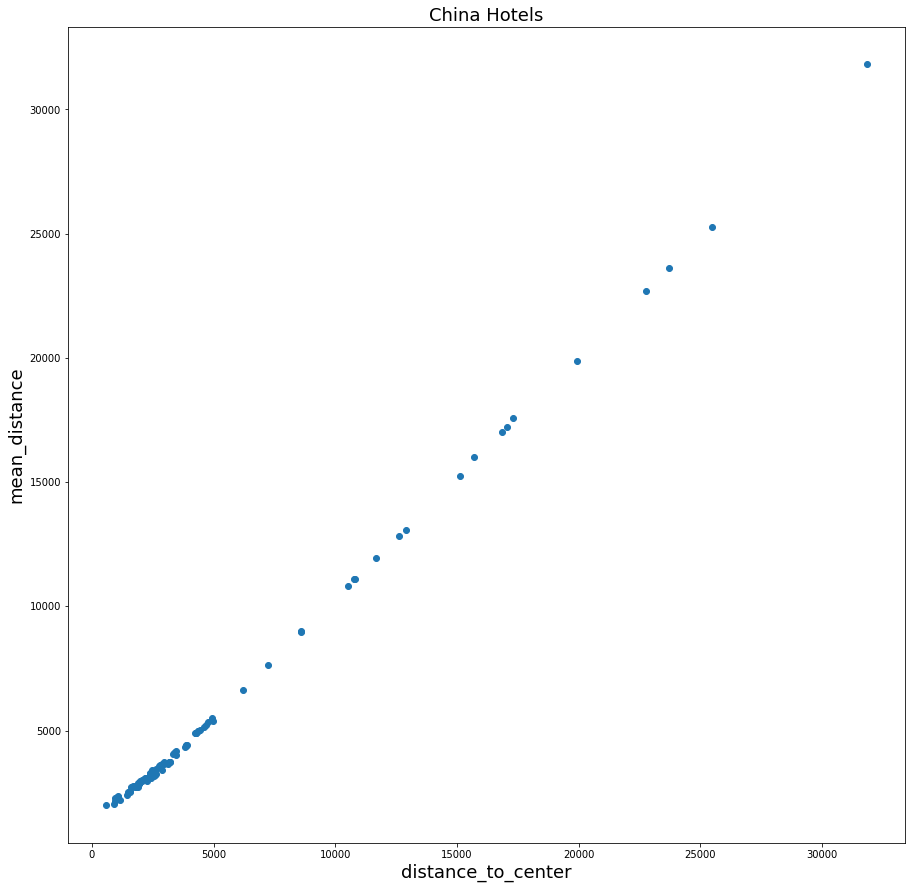

In [38]:
plt.figure(figsize=(15, 15))
plt.scatter(china_train.distance_to_center, china_train.mean_distance)
plt.title("China Hotels", fontsize=18)
plt.xlabel('distance_to_center', fontsize=18)
plt.ylabel('mean_distance', fontsize=18)
plt.show()

In [39]:
greece_distances = []
for i in range(len(greece_hotels)):
    per_bar_distance = []
    hotel_long = greece_hotels.iloc[i][6]
    hotel_lat = greece_hotels.iloc[i][7]
    hotel_coord = (hotel_lat, hotel_long)
    for j in range(len(greece_poi)):
        poi_long = greece_poi.iloc[j][5]
        poi_lat = greece_poi.iloc[j][6]
        poi_coord = (poi_lat, poi_long)
        hotel_poi_distance = geopy.distance.geodesic(hotel_coord, poi_coord).m
        per_bar_distance.append(hotel_poi_distance)
    greece_distances.append(per_bar_distance)

greece_hotels['nightlife_distance'] = greece_distances
greece_hotels['mean_distance'] = [statistics.mean(distance_list) for distance_list in greece_distances]
greece_hotels['median_distance'] = [statistics.median(distance_list) for distance_list in greece_distances]
greece_train = greece_hotels[["hotel_id", "city_id", "distance_to_center", "club_club_hotel", "party_people", "nightlife_distance", "mean_distance", "median_distance", "overall_rating"]]
greece_train = greece_train.fillna(0.0)
greece_train

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
0,11577919,14121,586,0.0,0.0,"[353.9821787813607, 441.74325280430025, 2115.3...",1293.526307,730.819012,5.0
1,11814291,14121,611,0.0,0.0,"[373.1103865443569, 429.9460795152224, 2133.32...",1307.848857,747.747328,0.0
2,214201,14121,626,0.0,0.0,"[799.1748830058161, 974.7072994339645, 1691.26...",1516.453535,974.707299,2.0
3,65997,14121,1483,0.0,0.0,"[1373.4512731073683, 1152.4303464423385, 2500....",2127.125076,1683.757859,2.0
4,77739,14121,857,0.0,0.0,"[833.4144350807193, 818.1352206819998, 2021.78...",1612.268975,1110.862364,3.0
...,...,...,...,...,...,...,...,...,...
95,14402835,14121,314,0.0,0.0,"[407.6914402154215, 896.4900975576476, 1874.76...",1119.324933,594.685718,0.0
96,2621611,14121,629,0.0,0.0,"[657.9723509838526, 765.7646263934315, 1891.74...",1449.591744,907.926760,1.0
97,18397931,14121,683,0.0,0.0,"[734.2669600448198, 828.5807895827518, 1871.45...",1504.170735,980.134300,0.0
98,8038679,14121,2162,0.0,0.0,"[2080.4885020945385, 1833.0963105354338, 2928....",2773.814249,2376.185574,5.0


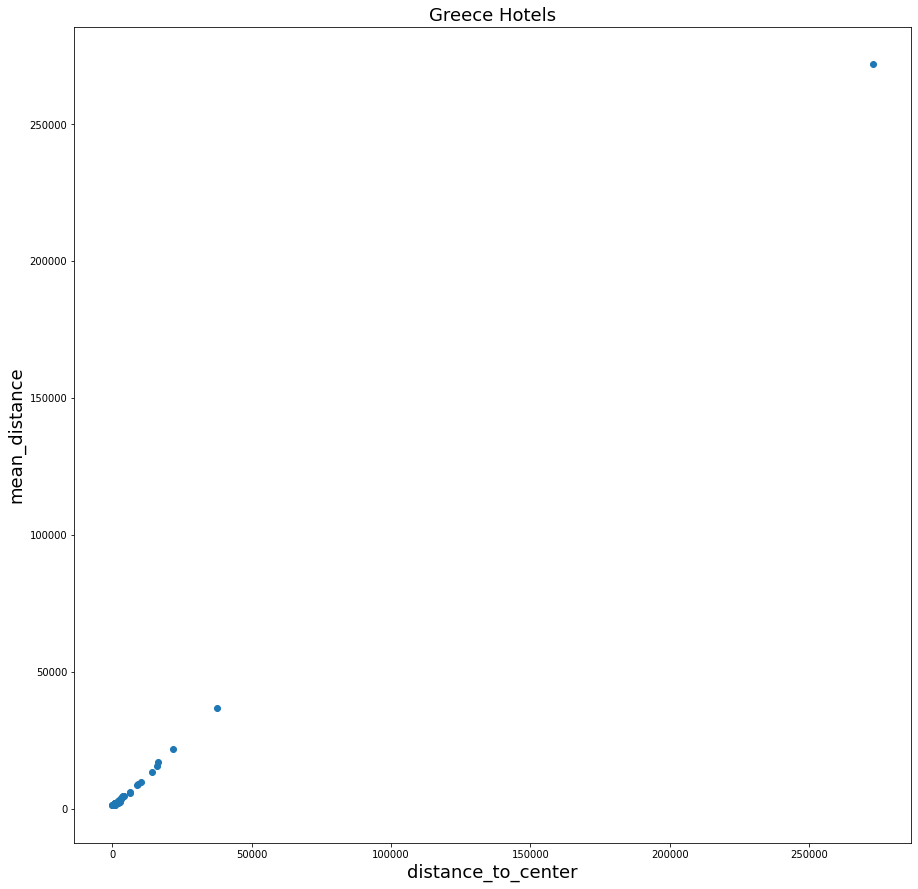

In [40]:
plt.figure(figsize=(15, 15))
plt.scatter(greece_train.distance_to_center, greece_train.mean_distance)
plt.title("Greece Hotels", fontsize=18)
plt.xlabel('distance_to_center', fontsize=18)
plt.ylabel('mean_distance', fontsize=18)
plt.show()

In [41]:
usa_distances = []
for i in range(len(usa_hotels)):
    per_bar_distance = []
    hotel_long = usa_hotels.iloc[i][6]
    hotel_lat = usa_hotels.iloc[i][7]
    hotel_coord = (hotel_lat, hotel_long)
    for j in range(len(usa_poi)):
        poi_long = usa_poi.iloc[j][5]
        poi_lat = usa_poi.iloc[j][6]
        poi_coord = (poi_lat, poi_long)
        hotel_poi_distance = geopy.distance.geodesic(hotel_coord, poi_coord).m
        per_bar_distance.append(hotel_poi_distance)
    usa_distances.append(per_bar_distance)

usa_hotels['nightlife_distance'] = usa_distances
usa_hotels['mean_distance'] = [statistics.mean(distance_list) for distance_list in usa_distances]
usa_hotels['median_distance'] = [statistics.median(distance_list) for distance_list in usa_distances]
usa_train = usa_hotels[["hotel_id", "city_id", "distance_to_center", "club_club_hotel", "party_people", "nightlife_distance", "mean_distance", "median_distance", "overall_rating"]]
usa_train = usa_train.fillna(0.0)
usa_train

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
0,15891,14257,15730,0.0,0.0,"[16436.494102494948, 11465.357885250512, 12413...",1.522013e+04,1.566600e+04,3.0
1,118915,14257,240,0.0,0.0,"[816.7384885794479, 14734.147020781955, 5106.3...",7.095438e+03,8.025684e+03,4.0
2,7033351,14257,4939,0.0,0.0,"[5512.868239864432, 9704.73377281262, 336.9602...",6.192234e+03,5.515160e+03,1.0
3,7170159,14257,17374,0.0,0.0,"[18076.424404265334, 12707.481603125398, 14120...",1.677244e+04,1.728007e+04,2.0
4,11935919,14257,5451,0.0,0.0,"[6158.307668556339, 11197.396105263617, 3530.4...",8.100019e+03,7.989924e+03,1.0
...,...,...,...,...,...,...,...,...,...
95,17962151,14257,16093,0.0,0.0,"[16159.285277274066, 12235.52629218558, 13364....",1.280358e+04,1.275965e+04,0.0
96,14361799,14257,8462,0.0,1.0,"[8763.379945501882, 8330.822116598758, 4957.18...",6.312330e+03,5.758282e+03,4.0
97,14986283,14257,17222,0.0,0.0,"[17922.801408557854, 12755.348122289926, 14012...",1.669015e+04,1.717827e+04,5.0
98,15451699,14257,3043545,0.0,0.0,"[3049377.122592237, 3064434.898861732, 3054991...",3.054695e+06,3.054454e+06,4.0


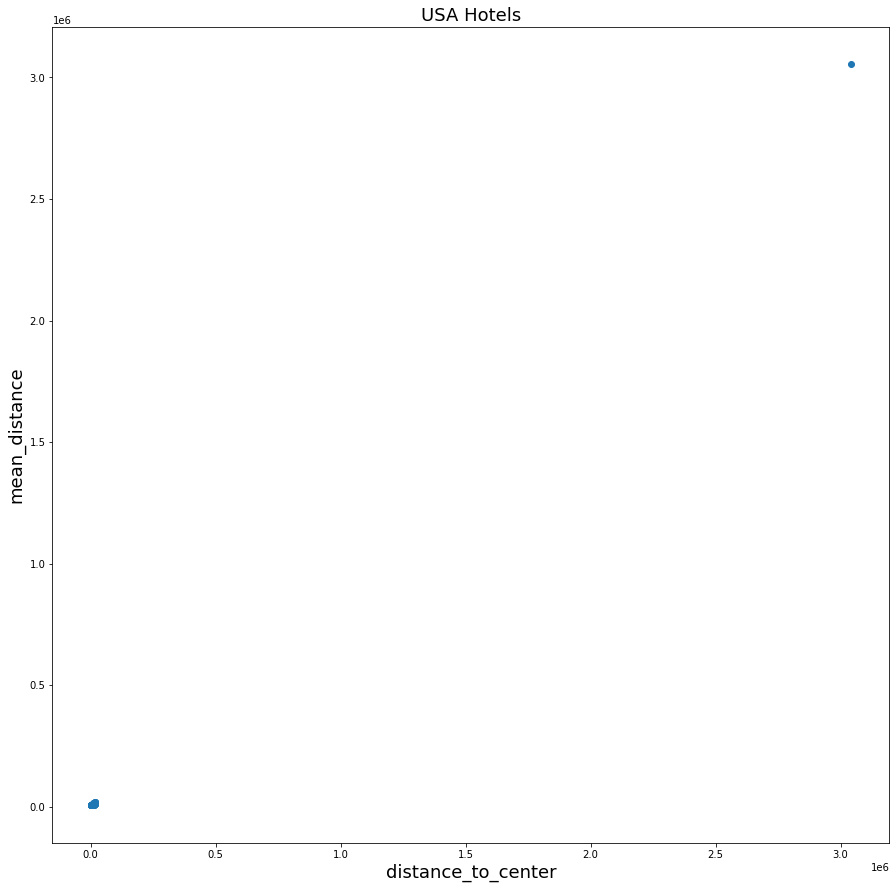

In [42]:
plt.figure(figsize=(15, 15))
plt.scatter(usa_train.distance_to_center, usa_train.mean_distance)
plt.title("USA Hotels", fontsize=18)
plt.xlabel('distance_to_center', fontsize=18)
plt.ylabel('mean_distance', fontsize=18)
plt.show()

In [43]:
neth_distances = []
for i in range(len(neth_hotels)):
    per_bar_distance = []
    hotel_long = neth_hotels.iloc[i][6]
    hotel_lat = neth_hotels.iloc[i][7]
    hotel_coord = (hotel_lat, hotel_long)
    for j in range(len(neth_poi)):
        poi_long = neth_poi.iloc[j][5]
        poi_lat = neth_poi.iloc[j][6]
        poi_coord = (poi_lat, poi_long)
        hotel_poi_distance = geopy.distance.geodesic(hotel_coord, poi_coord).m
        per_bar_distance.append(hotel_poi_distance)
    neth_distances.append(per_bar_distance)

neth_hotels['nightlife_distance'] = neth_distances
neth_hotels['mean_distance'] = [statistics.mean(distance_list) for distance_list in neth_distances]
neth_hotels['median_distance'] = [statistics.median(distance_list) for distance_list in neth_distances]
neth_train = neth_hotels[["hotel_id", "city_id", "distance_to_center", "club_club_hotel", "party_people", "nightlife_distance", "mean_distance", "median_distance", "overall_rating"]]
neth_train = neth_train.fillna(0.0)
neth_train

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
0,11530983,27561,6485,0.0,0.0,"[5865.988838596675, 7847.52943289905, 6388.388...",6976.258175,6858.284557,5.0
1,28219,27561,2597,0.0,0.0,"[2716.7160146892033, 3162.085956120007, 2790.8...",2543.618341,2424.741288,5.0
2,84187,27561,6875,0.0,0.0,"[6200.96585632988, 8271.49314902548, 7051.6501...",6651.264831,6664.465918,2.0
3,84201,27561,563,0.0,0.0,"[897.5569810020335, 2046.41261717062, 422.2287...",1726.400134,1538.791160,1.0
4,84265,27561,1367,0.0,0.0,"[1369.2259606344849, 2533.5682700692623, 1561....",1732.775365,1510.980330,4.0
...,...,...,...,...,...,...,...,...,...
95,8347043,27561,4518,0.0,0.0,"[3593.2675015945642, 6254.900407047997, 4603.8...",4629.253133,4455.498076,4.0
96,5411823,27561,7287,0.0,0.0,"[8150.386705745835, 5769.945821037521, 7347.37...",7240.221248,7376.785710,4.0
97,5441033,27561,847,0.0,0.0,"[966.5158334982187, 2263.179277050268, 706.592...",1886.158977,1746.461646,5.0
98,2656657,27561,1246,0.0,1.0,"[1509.4813551895713, 2184.707428692471, 1438.6...",1672.146732,1477.959532,2.0


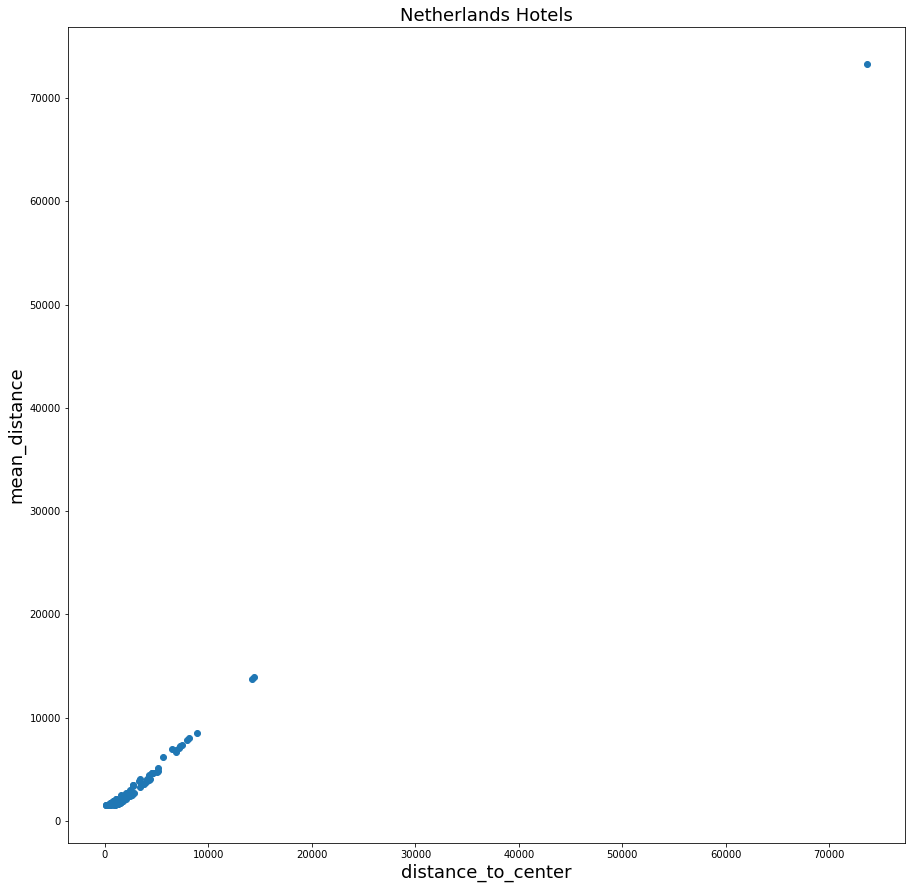

In [44]:
plt.figure(figsize=(15, 15))
plt.scatter(neth_train.distance_to_center, neth_train.mean_distance)
plt.title("Netherlands Hotels", fontsize=18)
plt.xlabel('distance_to_center', fontsize=18)
plt.ylabel('mean_distance', fontsize=18)
plt.show()

### __MERGE 4 CITY HOTELS DATA__

#### - After calculating the mean distance of each hotel in each city to the nightlife locations inside its own city area, finally I can merge all these data to put it in the process of  

#### assigning nightlife scores. Again, by doing that, I am calculating only the distance value inside their own city, not to  another nightlife location inside another city, so that I can 

#### give scores based on just __"distance"__ metric.

In [45]:
# CONCAT ALL 4 CITY HOTELS DATA
frames = [china_train, greece_train, usa_train, neth_train]
data = pd.concat(frames).reset_index()
del data['index']
data

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
0,11511119,31497,2799,0.0,0.0,"[3310.4779081444526, 3840.8280696398474, 3243....",3596.830569,3214.388401,0.0
1,11938295,31497,2870,0.0,0.0,"[2212.517293726446, 1036.416496603726, 3828.27...",3427.447094,3504.891936,3.0
2,33175,31497,1759,0.0,0.0,"[2119.4401781230654, 2667.460112399577, 2451.5...",2785.941616,2304.392865,5.0
3,108325,31497,2391,0.0,0.0,"[2924.361781062701, 3535.4066039559343, 2851.1...",3274.559983,2840.005266,3.0
4,6088555,31497,4268,0.0,0.0,"[4835.889191860594, 5330.8868226506365, 4553.9...",4895.846848,4583.472903,3.0
...,...,...,...,...,...,...,...,...,...
395,8347043,27561,4518,0.0,0.0,"[3593.2675015945642, 6254.900407047997, 4603.8...",4629.253133,4455.498076,4.0
396,5411823,27561,7287,0.0,0.0,"[8150.386705745835, 5769.945821037521, 7347.37...",7240.221248,7376.785710,4.0
397,5441033,27561,847,0.0,0.0,"[966.5158334982187, 2263.179277050268, 706.592...",1886.158977,1746.461646,5.0
398,2656657,27561,1246,0.0,1.0,"[1509.4813551895713, 2184.707428692471, 1438.6...",1672.146732,1477.959532,2.0


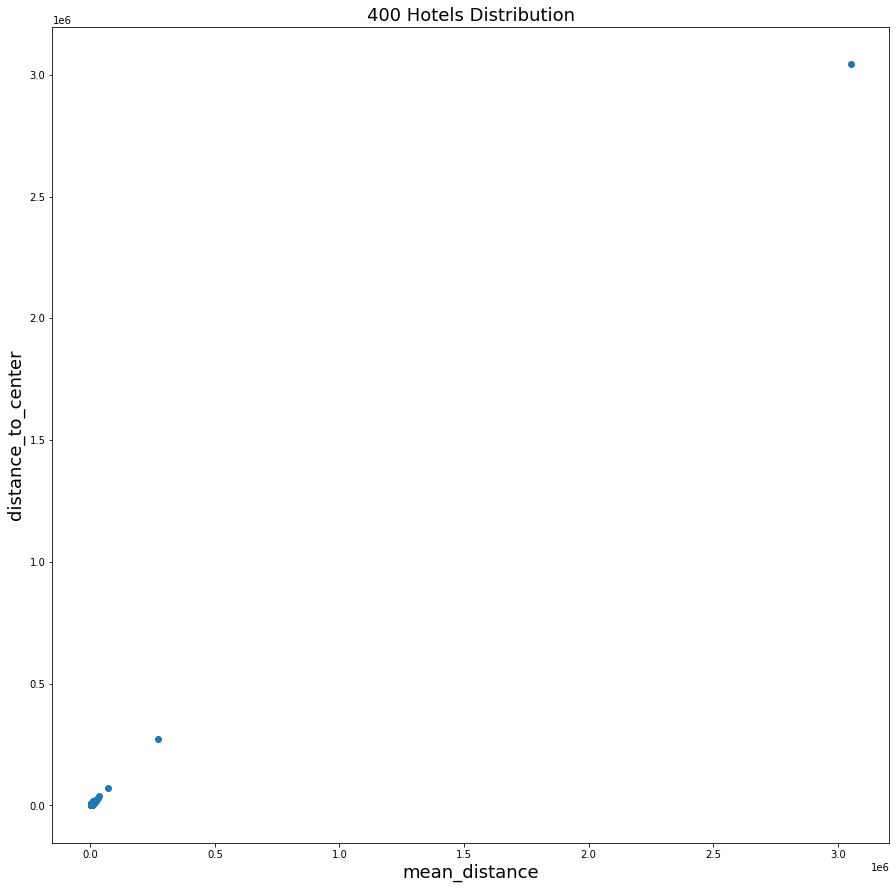

In [46]:
plt.figure(figsize=(15, 15))
plt.scatter(data.mean_distance, data.distance_to_center)
plt.title("400 Hotels Distribution", fontsize=18)
plt.xlabel('mean_distance', fontsize=18)
plt.ylabel('distance_to_center', fontsize=18)
plt.show()

#### I sorted the data by giving the first priority to the __"mean_distance"__ feature and the second to the __"distance_to_center"__ feature. The reason for counting distance to center when 

#### giving score to hotels but not keeping it as the priority feature is that there is a chance if a hotel is closer to the city center it might be closer to the nightlife locations, and 

#### this hypothesis is sort of being supported by the linear trend between those two features, but since this is an assumption I took it as a supportive feature.

In [47]:
data_sorted = data.sort_values(["mean_distance", "distance_to_center"], ascending=[True, True])
data_sorted

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating
195,14402835,14121,314,0.0,0.0,"[407.6914402154215, 896.4900975576476, 1874.76...",1.119325e+03,5.946857e+02,0.0
107,11491367,14121,458,0.0,1.0,"[507.7532414362579, 980.9408314636852, 1936.35...",1.142047e+03,6.884101e+02,5.0
164,14080779,14121,480,0.0,0.0,"[527.6101144735617, 997.848802420917, 1944.391...",1.148420e+03,7.104681e+02,0.0
173,11417571,14121,472,0.0,0.0,"[544.7598678031118, 1018.2333630849334, 1920.8...",1.151200e+03,7.220271e+02,0.0
169,14408791,14121,361,0.0,0.0,"[166.97320854099323, 580.607134496022, 1994.48...",1.163050e+03,5.798231e+02,0.0
...,...,...,...,...,...,...,...,...,...
84,4538307,31497,31842,0.0,0.0,"[32490.703490271408, 33886.39485847058, 30938....",3.182061e+04,3.124587e+04,4.0
190,15986963,14121,37557,0.0,0.0,"[37385.012344426446, 37539.20568851816, 38190....",3.690671e+04,3.725646e+04,0.0
319,84273,27561,73624,0.0,0.0,"[73430.75938981629, 74452.20650138255, 73991.6...",7.328915e+04,7.343938e+04,5.0
189,19636083,14121,272990,0.0,0.0,"[272495.5650219895, 272632.42685262894, 273318...",2.720205e+05,2.723849e+05,0.0


#### As I mentioned above, the correlation matrix also shows that they are correlated, but as 

#### description of the feature__(distance_to_center)__, it does not prove that hotel would be closer to 

#### nightlife locations if it is closer to the city center absolutely.

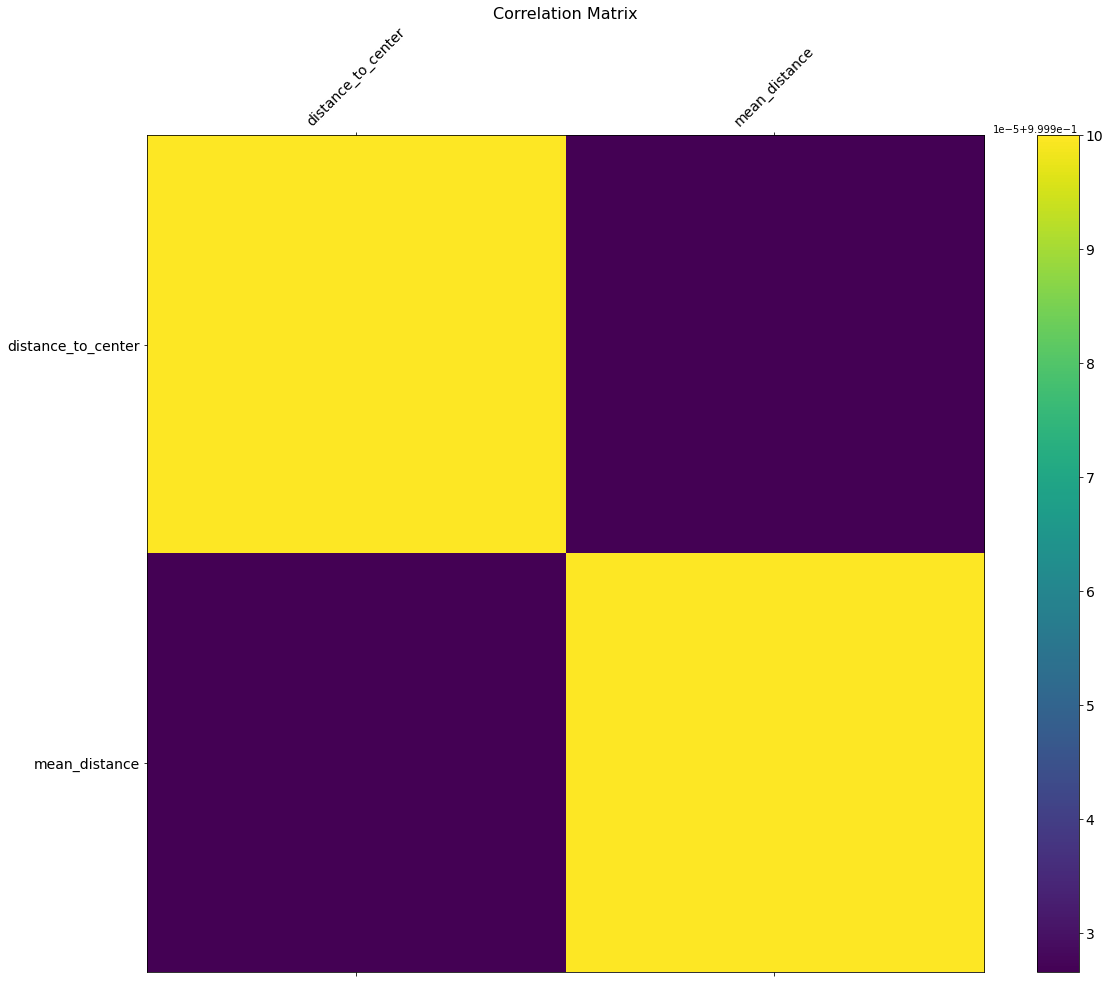

In [82]:
data_to_corr = data_sorted[["distance_to_center", "mean_distance"]]
f = plt.figure(figsize=(19, 15))
plt.matshow(data_to_corr.corr(), fignum=f.number)
plt.xticks(range(data_to_corr.shape[1]), data_to_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(data_to_corr.shape[1]), data_to_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.savefig('correlation_matrix.png')

## __HANDLING OUTLIERS__

#### __WINSORIZING__

#### To handle outliers and decrease the effect in the dataset I use __winsorizing__ method.

#### __Winsorizing__ limits the extreme values in the dataset to reduce the effect of outliers, by setting outliers to a specified percentile.

In [69]:
lower_bound = 0.1
upper_bound = 0.95
res = data_sorted[["distance_to_center", "mean_distance"]].quantile([lower_bound, upper_bound])
res

,distance_to_center,mean_distance
0.10,555.90,1514.387219
0.95,17222.05,16694.266006


In [50]:
# WINSORIZING DATA
X = StandardScaler().fit_transform(data_sorted[["mean_distance", "distance_to_center"]])
X = winsorize(X, limits=[0.01, 0.05])
len(X)

400

#### After winsorizing(handling outliers) the data points are more scattered than being extremely densed or extremely outside of the mean.

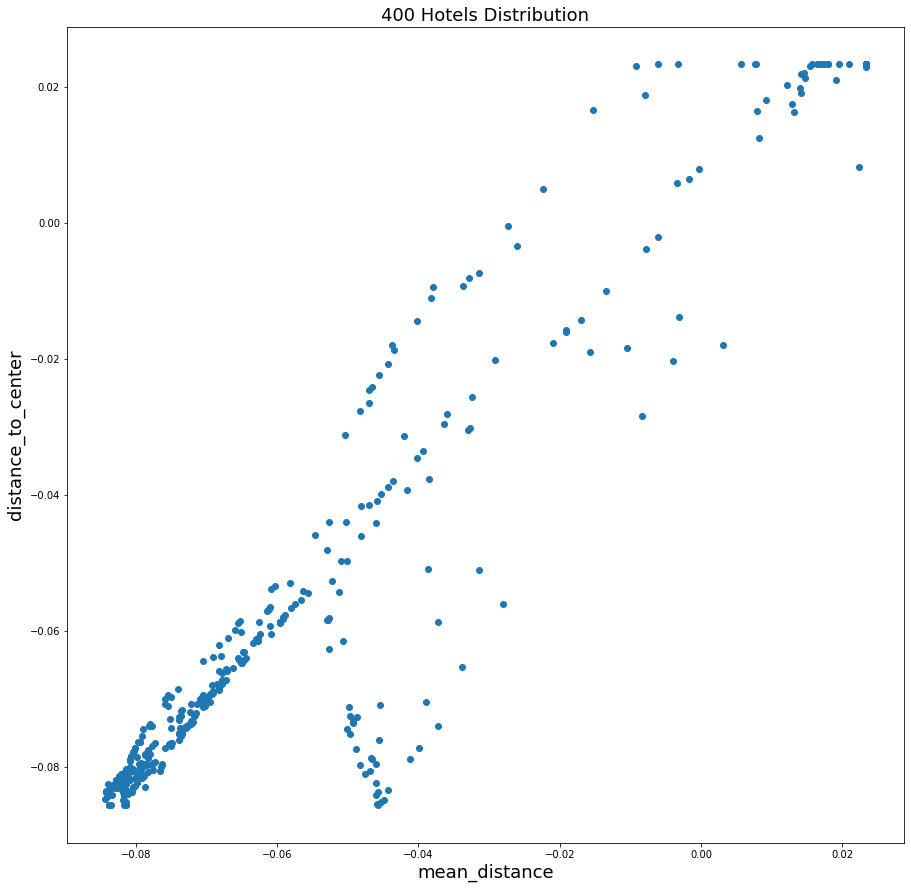

In [51]:
plt.figure(figsize=(15, 15))
plt.scatter(X[:, 0], X[:, 1])
plt.title("400 Hotels Distribution", fontsize=18)
plt.xlabel('mean_distance', fontsize=18)
plt.ylabel('distance_to_center', fontsize=18)
plt.show()

## __CLUSTERING__

#### - Elbow method is being used to determine the ideal number of clusters. This method tries number of cluster amounts to test to see until which point the sum of squared distances are 

#### being decreased significantly. Here, usually, the number that is on the elbow of the curve is being selected.

#### - From this plot I can see that elbow of the curve shows around k=40 (k-> number of k-means clusters)

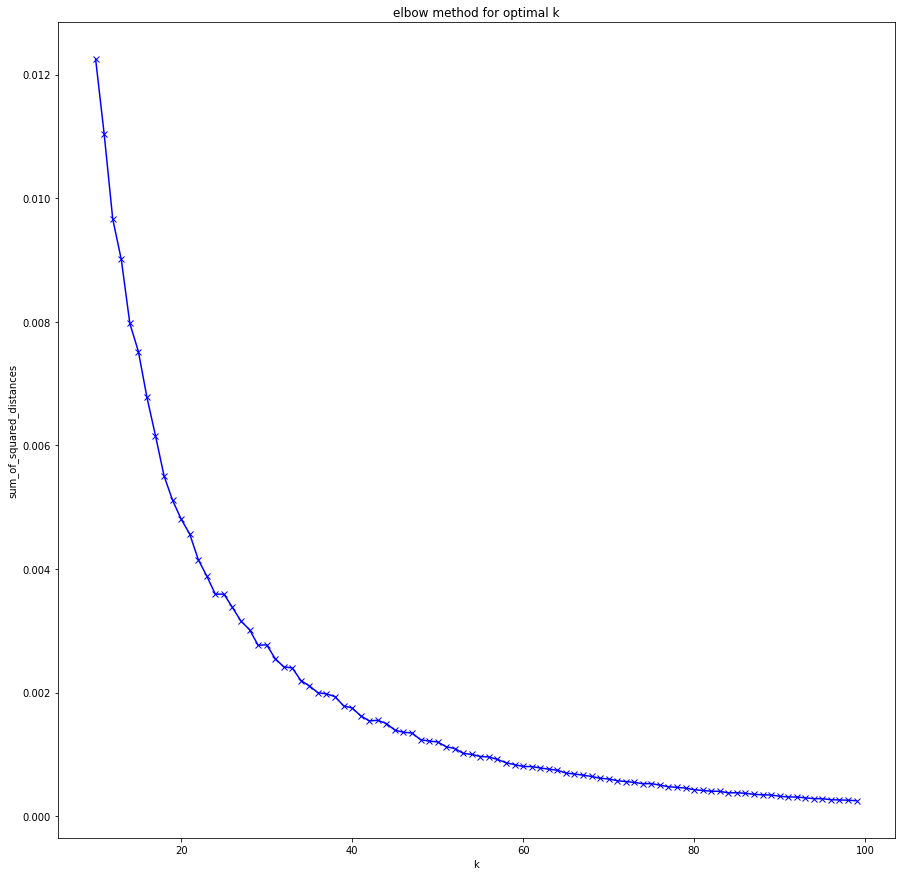

In [52]:
# ELBOW METHOD FOR #CLUSTERS
sum_of_squared_distances = []
K = range(10,100)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

plt.figure(figsize=(15,15))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

#### From elbow method I can see that elbow of the curve is around 40. Although, I chose 100 clusters to divide hotels for assigning scores from 1 to 100 according to their mean distance to 

#### nightlife locations and distance to city center. In addition to that, I use __sillhouette score__ and __calinski harabazs score__ to validate the number of clusters which gives higher 

#### score for 100 clusters. The reason is that the data is being spreaded/scattered enough to cluster them into 100.

Sillhouette Score:  0.44191264992755674
Calinski Score:  4660.001221331823


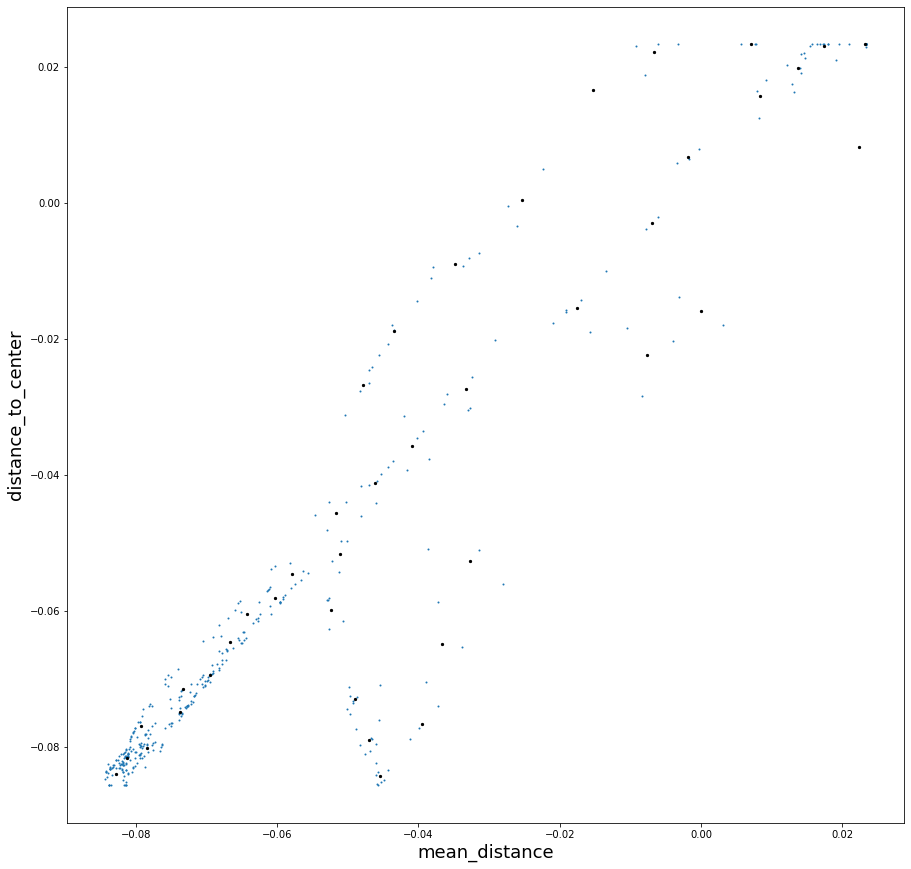

In [72]:
# K-MEANS CLUSTERING
k_means = KMeans(n_clusters=40)
model = k_means.fit(X)

y_hat = k_means.predict(X)
labels = k_means.labels_
sill_score = metrics.silhouette_score(X, labels, metric='euclidean')
cal_score = metrics.calinski_harabasz_score(X, labels)
print("Sillhouette Score: ", sill_score)
print("Calinski Score: ", cal_score)

plt.figure(figsize=(15, 15))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.scatter(k_means.cluster_centers_[:,0] ,k_means.cluster_centers_[:,1], color='black', s=5)
plt.xlabel("mean_distance", fontsize=18)
plt.ylabel("distance_to_center", fontsize=18)
plt.show()

Sillhouette Score:  0.47214150099452956
Calinski Score:  10535.495935993727


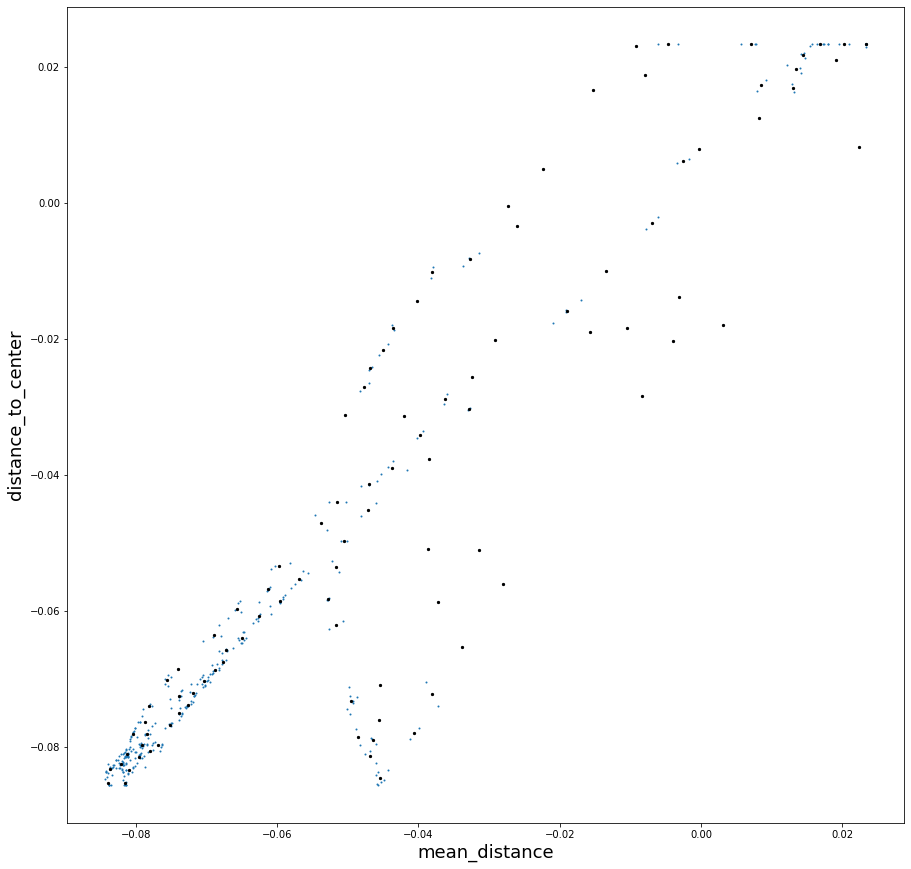

In [80]:
# K-MEANS CLUSTERING
k_means = KMeans(n_clusters=100)
model = k_means.fit(X)

y_hat = k_means.predict(X)
labels = k_means.labels_
sill_score = metrics.silhouette_score(X, labels, metric='euclidean')
cal_score = metrics.calinski_harabasz_score(X, labels)
print("Sillhouette Score: ", sill_score)
print("Calinski Score: ", cal_score)

plt.figure(figsize=(15, 15))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.scatter(k_means.cluster_centers_[:,0] ,k_means.cluster_centers_[:,1], color='black', s=5)
plt.xlabel("mean_distance", fontsize=18)
plt.ylabel("distance_to_center", fontsize=18)
plt.show()

#### Now that I have 100 clusters for the data points, I will calculate the magnitude of each data point to its own assigned cluster's centroid and sort them in descending order because the 

#### lower the distance a hotel has to each feature(left corner of the plot) the higher score it will take. By this I made a way of distinction of assigining different scores amongst the 

#### hotels.

In [81]:
def sorted_cluster(x, model=None):
    if model == None:
        model = KMeans()
    model = sorted_cluster_centers_(model, x)
    model = sorted_labels_(model, x)
    return model

def sorted_cluster_centers_(model, x):
    new_centroids = []
    magnitude = []
    for center in model.cluster_centers_:
        magnitude.append(np.sqrt(center.dot(center)))
    idx_argsort = np.argsort(magnitude)
    model.cluster_centers_ = model.cluster_centers_[idx_argsort]
    return model

def sorted_labels_(sorted_model, x):
    sorted_model.labels_ = sorted_model.predict(x)
    return sorted_model

In [65]:
k_means = sorted_cluster(X, k_means)
print(k_means.cluster_centers_)
print([score+1 for score in k_means.labels_])

[[-0.00336872  0.00584259]
 [-0.00099916  0.00723983]
 [-0.00691212 -0.00299347]
 [-0.00317589 -0.01381714]
 [ 0.008138    0.01255327]
 [-0.01347335 -0.00999934]
 [ 0.00313782 -0.01793014]
 [ 0.0085414   0.01732224]
 [-0.00794055  0.01888348]
 [-0.00401853 -0.02023263]
 [-0.01047893 -0.01835653]
 [ 0.01305058  0.01689258]
 [-0.01694337 -0.01423041]
 [-0.01527278  0.01662035]
 [-0.02239961  0.00505541]
 [-0.00473009  0.02333983]
 [ 0.02238807  0.00818444]
 [ 0.01345544  0.01973844]
 [ 0.00702493  0.02333983]
 [-0.01573282 -0.01890755]
 [-0.00918195  0.02305551]
 [-0.01907782 -0.01589332]
 [ 0.01444255  0.02176542]
 [-0.02610528 -0.0033149 ]
 [-0.02730701 -0.00046794]
 [-0.02088494 -0.01762183]
 [ 0.01914229  0.02095638]
 [ 0.01691193  0.02331249]
 [-0.00836944 -0.02832087]
 [ 0.02028022  0.02333983]
 [ 0.02333983  0.02330734]
 [-0.03264792 -0.0082435 ]
 [-0.02917199 -0.02019983]
 [-0.03810362 -0.01018301]
 [-0.0324764  -0.02561167]
 [-0.04015336 -0.01435505]
 [-0.03281318 -0.03029865]
 

In [66]:
data_sorted["score"] = [score+1 for score in k_means.labels_]
data_sorted

,hotel_id,city_id,distance_to_center,club_club_hotel,party_people,nightlife_distance,mean_distance,median_distance,overall_rating,score
195,14402835,14121,314,0.0,0.0,"[407.6914402154215, 896.4900975576476, 1874.76...",1.119325e+03,5.946857e+02,0.0,100
107,11491367,14121,458,0.0,1.0,"[507.7532414362579, 980.9408314636852, 1936.35...",1.142047e+03,6.884101e+02,5.0,99
164,14080779,14121,480,0.0,0.0,"[527.6101144735617, 997.848802420917, 1944.391...",1.148420e+03,7.104681e+02,0.0,99
173,11417571,14121,472,0.0,0.0,"[544.7598678031118, 1018.2333630849334, 1920.8...",1.151200e+03,7.220271e+02,0.0,99
169,14408791,14121,361,0.0,0.0,"[166.97320854099323, 580.607134496022, 1994.48...",1.163050e+03,5.798231e+02,0.0,99
...,...,...,...,...,...,...,...,...,...,...
84,4538307,31497,31842,0.0,0.0,"[32490.703490271408, 33886.39485847058, 30938....",3.182061e+04,3.124587e+04,4.0,31
190,15986963,14121,37557,0.0,0.0,"[37385.012344426446, 37539.20568851816, 38190....",3.690671e+04,3.725646e+04,0.0,31
319,84273,27561,73624,0.0,0.0,"[73430.75938981629, 74452.20650138255, 73991.6...",7.328915e+04,7.343938e+04,5.0,31
189,19636083,14121,272990,0.0,0.0,"[272495.5650219895, 272632.42685262894, 273318...",2.720205e+05,2.723849e+05,0.0,31


In [67]:
final_data = data_sorted[["hotel_id", "city_id", "score"]]
final_data

,hotel_id,city_id,score
195,14402835,14121,100
107,11491367,14121,99
164,14080779,14121,99
173,11417571,14121,99
169,14408791,14121,99
...,...,...,...
84,4538307,31497,31
190,15986963,14121,31
319,84273,27561,31
189,19636083,14121,31


In [68]:
final_data.to_csv('result_data.csv')